In [1]:
import numpy as np 
import yaml
from scipy.interpolate import interp1d, make_interp_spline
import pickle
import h5py
import matplotlib.pyplot as plt
from scipy.stats import norm
from classy import Class
import time
from train_pybird_emulators.emu_utils import emu_utils
from tqdm import tqdm 

# In this file we find the priors for the different reduced-space parameters given our bank

In [2]:
# filename = "/cluster/scratch/areeves/pk_bank_lss_sigma_new2/total_data.h5"
filename = "/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/lhc_pk_bank/pk_bank_new.h5"
with h5py.File(filename, 'r') as hdf_file:
    print(hdf_file.keys())
    lhc_pk_lin = hdf_file["pk_lin"][:]
    cosmo_params = hdf_file["params"][:]

<KeysViewHDF5 ['D', 'bpk', 'f', 'kk', 'params', 'pk_lin']>


In [3]:
lhc_pk_lin.shape 

(159200, 1000)

In [4]:
# param_names = ["omega_cdm", "omega_b", "h", "Omega_k", "n_s", "N_ur", "m_ncdm", "w0_fld", "z"]
param_names = cosmo_params.dtype.names

In [5]:
knots = np.load("../data/knots_data/final_knots_80.npy")

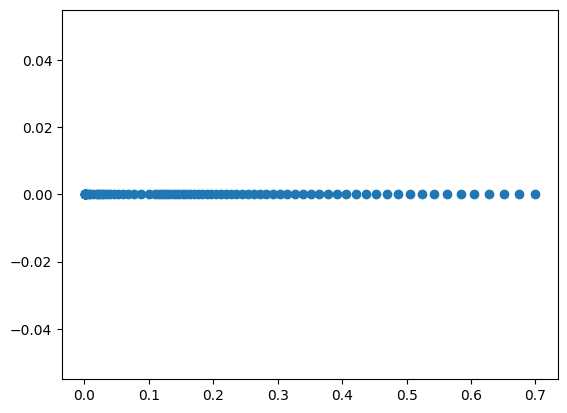

In [6]:
plt.scatter(knots, np.zeros_like(knots))

In [7]:
knots 

array([1.00000000e-04, 1.46002162e-04, 2.13166312e-04, 3.11227423e-04,
       4.54398764e-04, 6.63432018e-04, 9.68625086e-04, 1.41421356e-03,
       2.06478237e-03, 3.01462689e-03, 4.40142042e-03, 6.42616895e-03,
       9.38234557e-03, 1.36984273e-02, 2.00000000e-02, 2.10000000e-02,
       2.39166870e-02, 2.72384723e-02, 3.10216198e-02, 3.53302082e-02,
       4.02372158e-02, 4.58257569e-02, 5.21904898e-02, 5.94392195e-02,
       6.76947243e-02, 7.70968349e-02, 8.78048033e-02, 1.00000000e-01,
       1.10000000e-01, 1.14064792e-01, 1.18279789e-01, 1.22650542e-01,
       1.27182805e-01, 1.31882548e-01, 1.36755958e-01, 1.41809454e-01,
       1.47049690e-01, 1.52483567e-01, 1.58118240e-01, 1.63961129e-01,
       1.70019928e-01, 1.76302616e-01, 1.82817466e-01, 1.89573057e-01,
       1.96578285e-01, 2.03842375e-01, 2.11374892e-01, 2.19185756e-01,
       2.27285252e-01, 2.35684046e-01, 2.44393197e-01, 2.53424175e-01,
       2.62788871e-01, 2.72499618e-01, 2.82569203e-01, 2.93010886e-01,
      

In [8]:
#Function to loop through bnk and extract the parameters and store in an array

k_l, k_r =  1e-4, 0.7 #In Mpc/h
n_k = 1000

kk = np.logspace(np.log10(k_l)-1e-10, np.log10(k_r)+1e-10, n_k)

def get_spline_params(knots, ilogpk, with_logknots=False):
    logknots = np.log( np.unique(knots) ) # sorting and removing duplicates
    logpk = ilogpk(logknots)
    if with_logknots: return logknots, logpk
    else: return logpk

def get_logslope(x, f, side='left'):
    if side == 'left': 
        n = (np.log(f[1]) - np.log(f[0])) / (np.log(x[1]) - np.log(x[0]))
        A = f[0] / x[0]**n
    elif side == 'right':
        n = (np.log(f[-1]) - np.log(f[-2])) / (np.log(x[-1]) - np.log(x[-2]))
        A = f[-1] / x[-1]**n
    return A, n

M = Class()
M.set({
"N_ncdm": 1,
"T_ncdm": 0.71611,
"Omega_Lambda": 0,
})

def get_params_tot(knots, lhc_pk_lin, kk):

    param_array = []
    for i in tqdm(range(150000)):
        param_realization = []
        pk_i = 1.*lhc_pk_lin[i]
        pk_max = np.max(pk_i)
        
        cosmo_params_i = cosmo_params[i]
        M.set({key:val for key, val in zip(param_names, cosmo_params_i) if key != "z"})
        M.compute()
        f = M.scale_independent_growth_factor_f(cosmo_params_i[-1])
        

        pk = 1.*pk_i / pk_max # normalizing
        #Get the spline params
        ilogpk = interp1d(np.log(kk), np.log(pk), kind = 'cubic')
        spline_params = get_spline_params(knots,ilogpk)
        param_realization.extend(list(spline_params))
        param_realization.append(pk_max)
        param_realization.append(f)

        param_array.append(param_realization)



    #Get the pkmax param- I dont think we need this as we will not train the emulator over this?
    param_array = np.array(param_array)

    return param_array

In [9]:
start = time.time()
param_array = get_params_tot(knots, lhc_pk_lin, kk)
end = time.time()

100%|██████████| 150000/150000 [2:00:33<00:00, 20.74it/s] 


In [10]:
np.save("params_array_from_lhc.npy_new", param_array)

# param_array = np.load("params_array_from_lhc_new.npy")

In [11]:
print("time", end-start)

time 7234.451772689819


In [12]:
param_array.shape

(150000, 82)

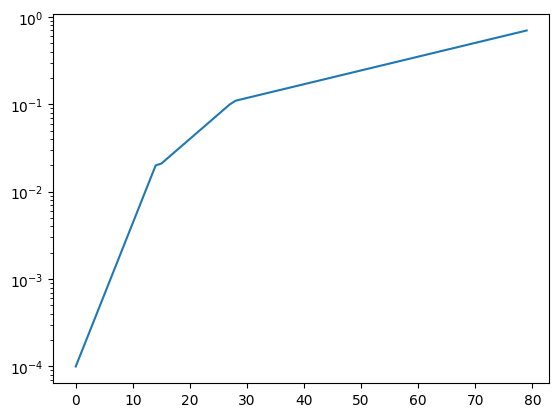

In [13]:
plt.plot(knots)
plt.yscale('log')

In [14]:
param_array.shape 

(150000, 82)

In [15]:
np.std(param_array[:,-3])

0.9719325074524651

In [16]:
covariance = np.cov(param_array.T)

In [17]:
covariance_reduced = np.cov(param_array[:-2,:-2].T)

In [18]:
mu = np.mean(param_array, axis=0)

In [19]:
mu.shape 

(82,)

In [20]:
# save 

np.save("../data/knots_data/covariance_80_knots_new.npy", covariance)
np.save("../data/knots_data/mu_80_knots_new.npy", mu)


In [21]:
np.linalg.inv(covariance)

array([[ 3.00157538e+01, -5.17092866e+01,  1.00902488e+01, ...,
         9.49187790e+03,  2.00405301e-05,  4.86146329e+00],
       [-5.17092890e+01,  1.37400108e+02, -1.09596394e+02, ...,
        -2.07952027e+04, -2.87677627e-05, -6.97184670e+00],
       [ 1.00902532e+01, -1.09596402e+02,  2.24839171e+02, ...,
         1.03747808e+04,  1.01429066e-07, -2.62412099e+00],
       ...,
       [ 9.49184948e+03, -2.07952458e+04,  1.03749846e+04, ...,
         1.07955387e+09,  4.06498771e-02,  2.59452096e+04],
       [ 2.00406024e-05, -2.87678717e-05,  1.01386186e-07, ...,
         4.06515242e-02,  9.42849252e-08,  5.17984218e-03],
       [ 4.86145600e+00, -6.97184535e+00, -2.62409542e+00, ...,
         2.59452306e+04,  5.17984266e-03,  4.19965461e+02]])

In [22]:
modified_cov = covariance.copy()
num_uncorrelated=2
n = covariance.shape[0]
for i in range(n - num_uncorrelated, n):
        for j in range(n):
            if i != j:  # Preserve diagonal elements
                modified_cov[i, j] = 0
                modified_cov[j, i] = 0  # Ensure symmetry

In [23]:
eps=1e-12
# a=np.linalg.cholesky(covariance_reduced+eps)
b = np.linalg.cholesky(covariance)

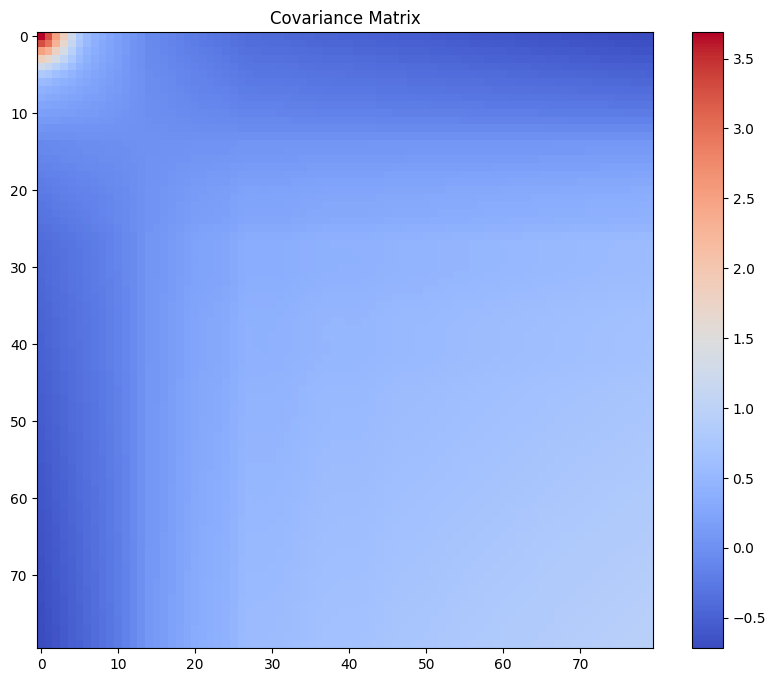

In [24]:
# Plotting the covariance matrix with log scale and colorbar
plt.figure(figsize=(10, 8))
plt.imshow(covariance[:-2, :-2], cmap='coolwarm')
# plt.imshow(modified_cov, cmap='coolwarm')

plt.colorbar()
plt.title("Covariance Matrix")
plt.show()

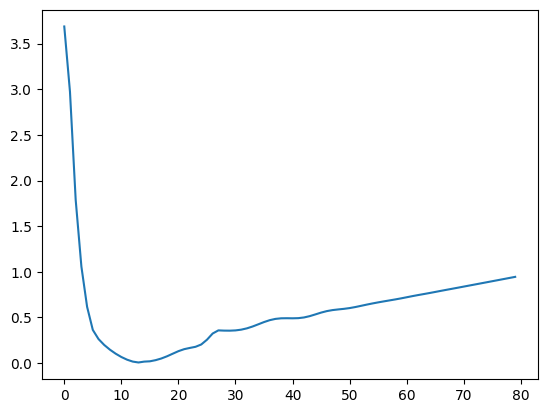

In [25]:
plt.plot(np.diag(covariance[:-2]))

In [26]:
covariance[-3,-3]

0.9446590967701477

/scratch/tmp.8598255.areeves/ipykernel_636678/2230540156.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


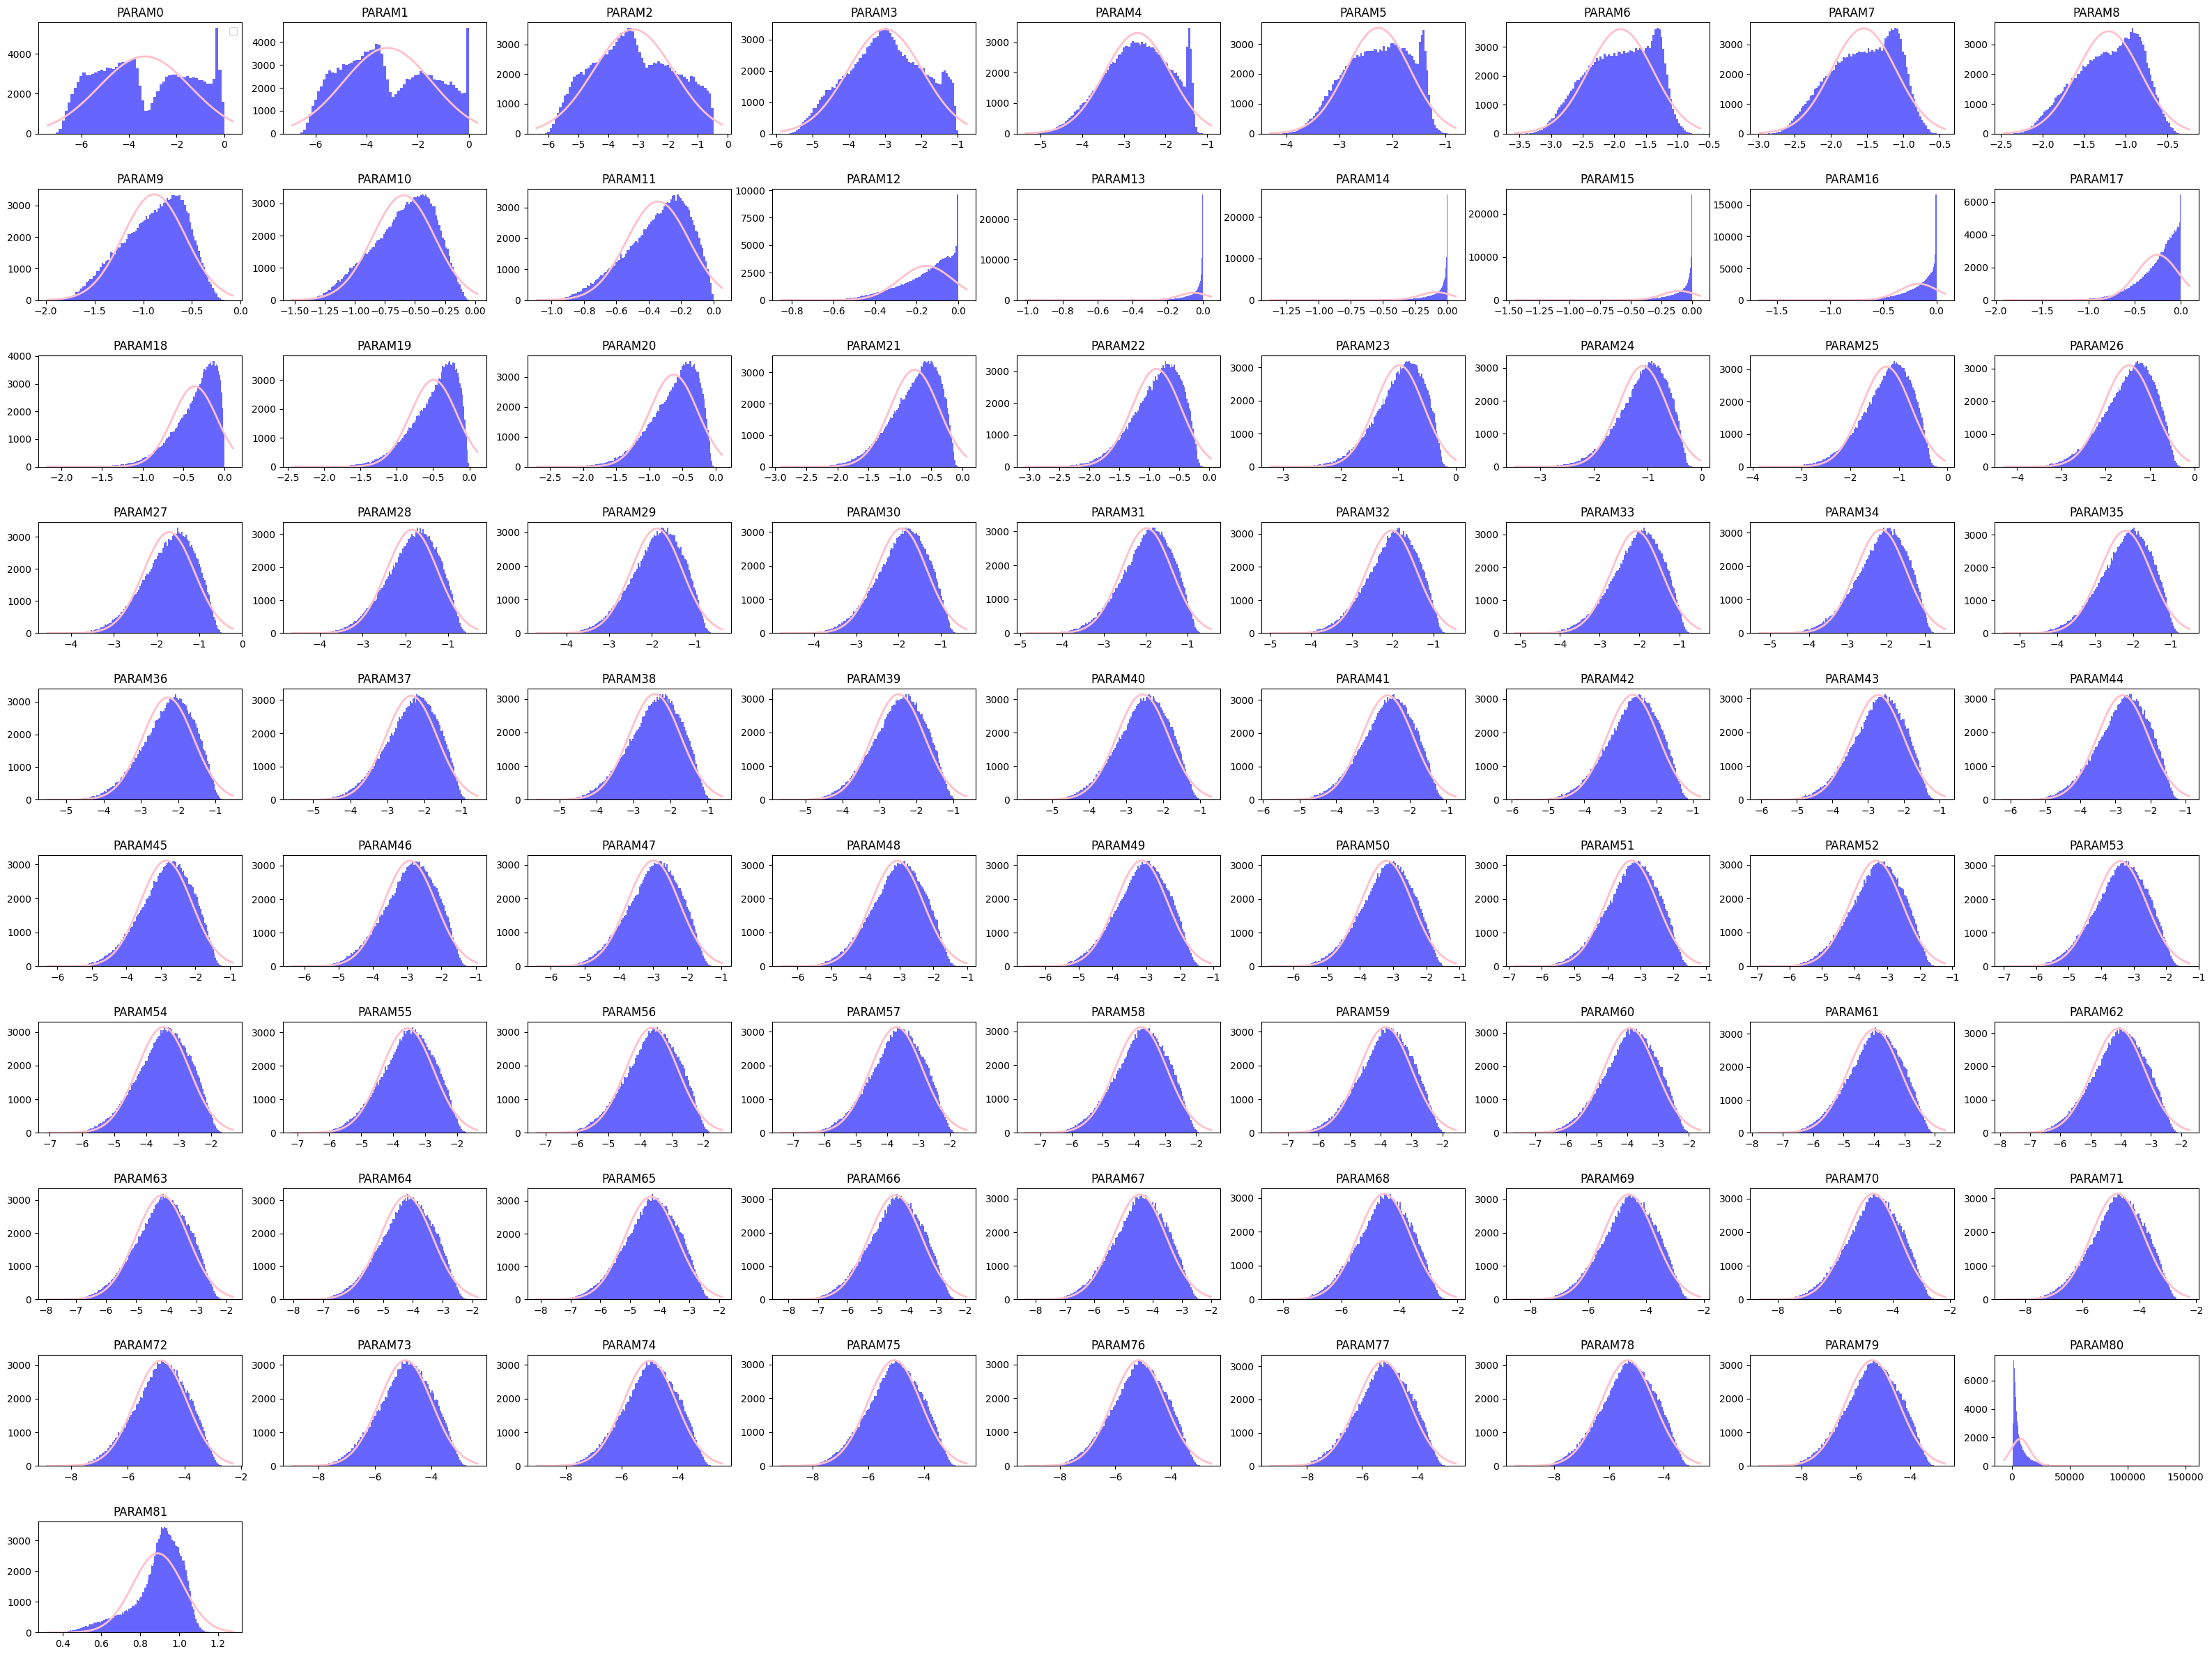

In [27]:
#Plot histograms to see how gaussian the distributions are

def plot_histograms(compressed_array):
    means = []
    sigmas = []
    num_data_points = compressed_array.shape[1]
    num_realizations = compressed_array.shape[0]
    num_rows = int(np.ceil(np.sqrt(num_data_points)))
    num_cols = int(np.ceil(num_data_points / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 30))
    fig.subplots_adjust(hspace=0.5)

    for i, ax in enumerate(axes.flatten()):
        if i < num_data_points:
            # Get the data for the current data point
            data = compressed_array[:, i]

            mu, sigma = norm.fit(data)

            # Store the mean and standard deviation
            means.append(mu)
            sigmas.append(sigma)

            # Plot the histogram for the current data point
            counts, bins, _ = ax.hist(data, bins='auto', density=False, alpha=0.6, color='blue')
            # Plot the PDF of the Gaussian distribution

            bin_width = bins[1] - bins[0]
            xmin, xmax = ax.get_xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, sigma)

            scaled_p = p * bin_width * num_realizations  # scaling factor

            ax.plot(x, scaled_p, color='pink', linewidth=2)

            # Plot vertical lines at the 5th and 95th percentile values
            if i==0:
                ax.legend()

            ax.set_title(f'PARAM{i}')
        else:
            ax.axis('off')

    return means, sigmas

means, sigmas =plot_histograms(param_array)

In [28]:
param_names = [f"pk_knot_{i+1}" for i in range(80)]
param_names.extend(["pk_max", "f"])

In [29]:
#create a quick pandas frmae with these column headers 
import pandas as pd
df = pd.DataFrame(param_array, columns=param_names)

In [30]:
# fit a normalizing flow to the data 
from pzflow import Flow
flow = Flow(data_columns=param_names)

In [31]:
losses = flow.train(df, verbose=True)

Training 100 epochs 
Loss:
(0) 520.6252


2024-09-17 17:08:00.504374: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-09-17 17:09:38.646758: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m38.142527861s

********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


(1) -3.6916
(6) -107.0787
(11) -177.4813
(16) -194.7190


In [ ]:
def generate_yaml_file(means, sigmas, filename):
    parameter_info = list(zip(means, sigmas))
    yaml_data = {'parameters': []}

    for i, (mean, sigma) in enumerate(parameter_info):
        if i == len(parameter_info)-1:
            parameter_name = "f"
        elif i == len(parameter_info)-2:
            parameter_name = "pk_max"
        else:
            parameter_name = f'pk_knot_{i+1}'
        # set the limits as being 10X wider than the gaussian priors
        upper_prior = mean.item() + (sigma.item() * 10)
        lower_prior = mean.item() - (sigma.item() * 10)

        # Apply the condition for all parameters except for the last four which are the log scaling parameters, pkmax and f
        if i < len(parameter_info) - 4 and upper_prior > 0:
            upper_prior = 0

        # Apply that the pkmax must be positive
        if i == len(parameter_info)-2 and lower_prior < 0:
            lower_prior = 0

        parameter_prior = [lower_prior, upper_prior]  # Convert numpy scalars to Python scalars

        parameter_data = {'name': parameter_name, 'prior': parameter_prior}
        yaml_data['parameters'].append(parameter_data)

    with open(filename, 'w') as yaml_file:
        yaml.dump(yaml_data, yaml_file, default_flow_style=False)

In [ ]:
generate_yaml_file(means, sigmas, "../configs/config_pybird_80_knots_10sigma.yaml")